# Tensors
## CP-ALS

In [1]:
import numpy as np
import tensorly as tl
import scipy as sp
import scipy.io as sio
from tensorly.decomposition import parafac, tucker
import matplotlib.pyplot as plt
%matplotlib inline

Using numpy backend.


In [2]:
data = sio.loadmat("data/claus.mat")
X = data['X']
print(X.shape)

(5, 201, 61)


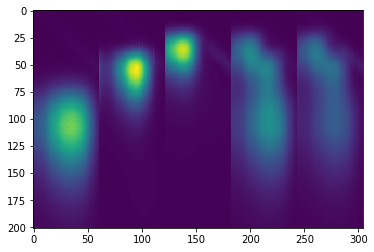

In [3]:
plt.imshow(tl.unfold(X, 1))

In [4]:
ys = tl.unfold(X, 2)
ys.shape

(61, 1005)

In [5]:
factors = tl.decomposition.parafac(X, rank=2)

In [6]:
core, factors = tl.decomposition.tucker(X, ranks=[3, 10, 3])

In [7]:
def model(factors, shape):
    M0 = factors[0] @ tl.tenalg.khatri_rao(factors, skip_matrix=0).T
    return tl.fold(M0, 0, shape)

In [8]:
def CPALS(tensor, r, iters=5, tol=1e-5, normalize = False):
    d = len(tensor.shape)
    A = [np.random.rand(nk, r) for nk in [*tensor.shape]]
    Grams = [X.T @ X for X in A]
    lambdas = [np.zeros((X.shape[1])) for X in A]
    fit = 0.0
    fitnesses = []
    for i in range(iters):
        oldfit = fit
        for k in range(d):
            B = tl.unfold(tensor, k) @ tl.tenalg.khatri_rao(A, skip_matrix=k)
            V = np.multiply.reduce(Grams[0:k] + Grams[k+1:])
            A[k] = np.linalg.solve(V, B.T).T
            if normalize:  
                for j in range(A[k].shape[1]):
                    lambdas[k][j] = np.linalg.norm(A[k][:, j])
                    A[k][: j] /= lambdas[k][j]
            Grams[k] = A[k].T @ A[k]
        M = model(A, tensor.shape)
        fit = 1.0 - tl.norm(X - M) / tl.norm(X)
        fitnesses.append(fit)
        if abs(fit - oldfit) < tol:
            break
    # [A[k] * lambdas[k] for k in range(d)]
    return A, fitnesses

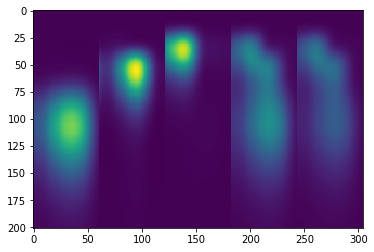

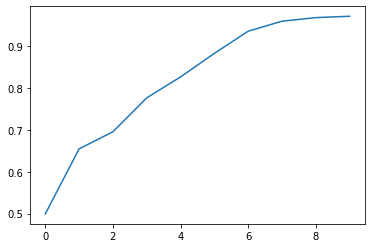

In [9]:
factors, fitnesses = CPALS(X, 3, 10, normalize=False)
plt.imshow(tl.unfold(model(factors, X.shape), 1))
plt.show()
plt.plot(fitnesses)

## Determining the rank

Rank 2
Rank 4


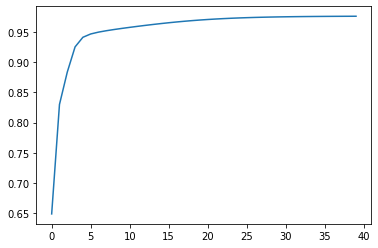

In [10]:
print("Rank 2")
factors, fitnesses2 = CPALS(X, 2, 10, normalize=False)

print("Rank 4")
factors, fitnesses4 = CPALS(X, 4, 40, normalize=False)

plt.plot(fitnesses4)

## CP-OPT

## Notes

- _Trick 1_. Do not unfold $X$
- _Trick 2_. Sampled Kathri-Rao
    $Z_s = \text{SKR}(\mathcal{S}, \{ A_k \}, k)$
    1. Retrieve $s \times (d - 1)$ array of sampled indices from $\mathcal{S} = \text{idxs}$.
    2. $Z_s = \text{ones}(s, r)$
    3. for $\ell = 1, \ldots, k - 1, k + 1, \ldots d$, form $\hat{A}_k = A_k(\text{idxs}(:, \ell), :)$, and set $Z_s = Z_s * \hat{A}_k$.  
- _Trick 5_. Compute the loss at a (fixed across all iterations) subset of tensor entries $\Omega \subset \mathcal{I}$. Do not check every iteration.
    $$\hat{F} = \frac{n^d}{| \Omega |} \sum_{i \in \Omega} (x_i - m_i)^2.$$ 
    
Mixing on Zk:

$$\Phi = S \mathcal{F} D$$

In [84]:
import math

## JLTs

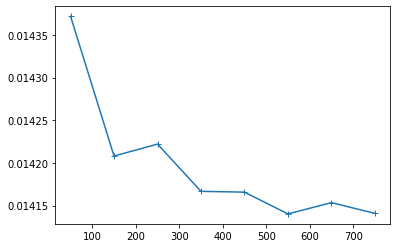

In [93]:
p = 1000
n = 5000
vs = [np.random.randn(n, 1) for _ in range(0, p)]

ms = np.arange(50, 850, 100)
means = []
for m in ms:
    Phi = (1.0 / math.sqrt(m)) * np.random.randn(m, n)
    dev = 0.0
    for v in vs:
        vnorm = np.linalg.norm(v)
        phivnorm = np.linalg.norm(Phi @ v)
        dev += abs(vnorm / phivnorm) / vnorm
    means.append(dev / p)

plt.plot(ms, means, marker='+')

In [371]:
def transform(A, b):
    m, n = A.shape
    D = 2 * np.random.randint(0, 2, size=(m,1)) - 1
    FDA = sp.fft(D * A, axis=0)
    r = 500
    S = np.random.randint(0, m, size=(r,))
    FDb = sp.fft(D * b, axis=0)
    A_ = FDA[S, :]
    b_ = FDb[S, :]
    return np.concatenate((np.real(A_), np.imag(A_))), np.concatenate((np.real(b_), np.imag(b_)))

## Application to overdetermined LS

In [372]:
def solve_ls(A, b):
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    return x

In [373]:
n = 50000
p = 100

A = np.random.randn(n, p)
b = np.random.rand(n, 1)

In [374]:
%%timeit

x = solve_ls(A, b)

182 ms ± 8.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [375]:
%%timeit

A_, b_ = transform(A, b)

125 ms ± 6.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [376]:
%%timeit

x_ = solve_ls(A_, b_)

4.33 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [377]:
print(np.linalg.norm(b - A @ x_), np.linalg.norm(b - A @ x[0]))

129.21005966085266 130.2349509775944


## CPARLS

In [88]:
def CPARLS(tensor):
    d = len(tensor.shape)
    A = [np.random.rand(nk, r) for nk in [*tensor.shape]]
    while True:
        for k in range(d):
            Nk = np.multiply.reduce([*tensor.shape])
            # 1. random sample of indices S = np.ones(s, Nk)
            # 2. Zs = SKR(S, A, k)
            # 3. Xs.T = S X_(k).T
            # 4. A_k = Xs.T \ Zs.T
        # check if converged

## CP-OPT

In [379]:
import scipy.optimize

In [384]:
def loss():
    pass

def grad():
    pass

In [381]:
ans = scipy.optimize.minimize(fun, np.rand(), jac)

NameError: name 'fun' is not defined